In [1]:
%pip install scikit-learn numpy pandas tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

# Load data
data = pd.read_csv("data/train_data.csv").sort_values("popularity", ascending=False)

data.columns

Index(['Unnamed: 0', 'row_id', 'popularity', 'duration_ms', 'explicit',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'track_genre'],
      dtype='object')

In [3]:
from sklearn.model_selection import KFold

CATEGORICAL_COLS = ["track_genre", "key"]
DROP_COLS = ["Unnamed: 0", "row_id", "mode", "time_signature", "explicit"]

K = 5
KF = KFold(n_splits=K, shuffle=True)

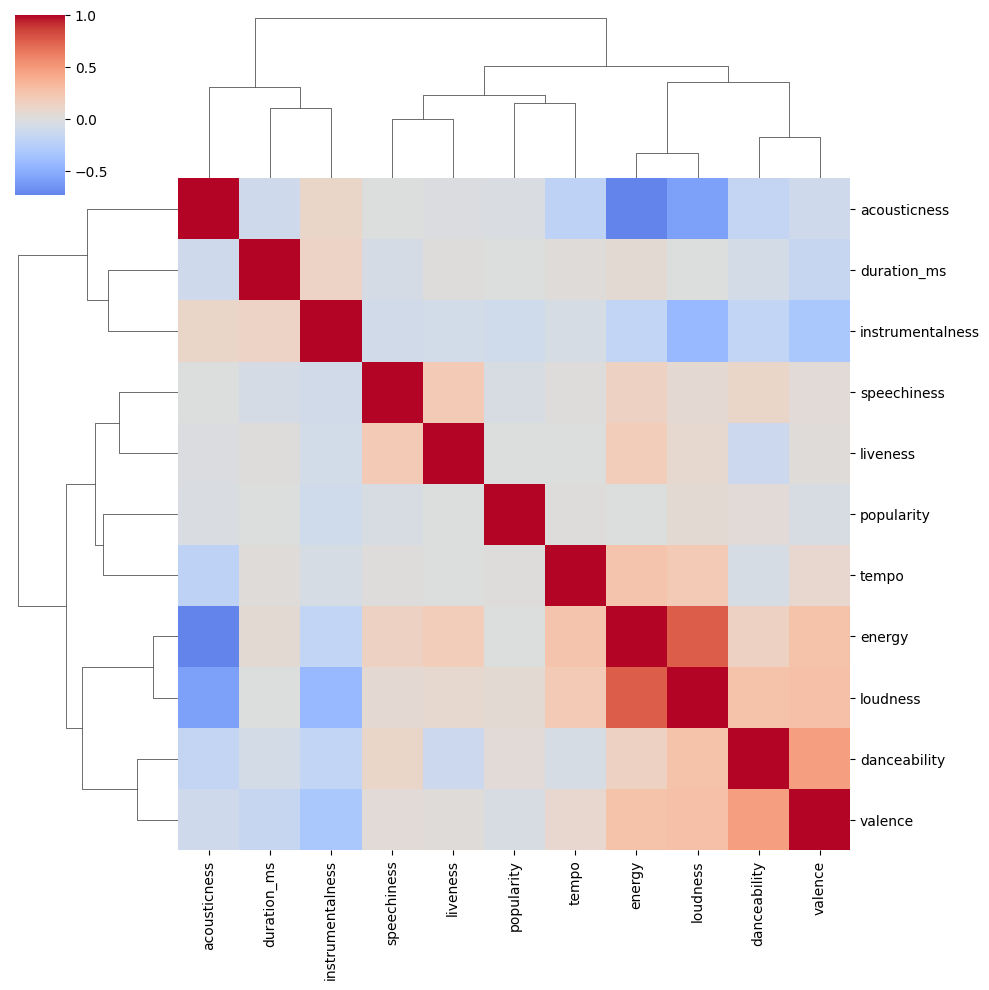

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.clustermap(
    data.drop(DROP_COLS + CATEGORICAL_COLS, axis=1).corr(),
    cmap="coolwarm",
    center=0,
    method="ward",
)
plt.show()

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

global_stats = {}


def categorical_data(data: pd.DataFrame) -> pd.DataFrame:
    return pd.get_dummies(data[CATEGORICAL_COLS], drop_first=True)


def prepare_data(data: pd.DataFrame, reset=False) -> pd.DataFrame:
    global global_stats
    data = data.copy()

    global_stats = global_stats if not reset else {}
    is_set = global_stats != {}

    if not is_set:
        global_stats["mean_categorical_popularity"] = {
            col: data.groupby(col)["popularity"].mean() for col in CATEGORICAL_COLS
        }

    for col in CATEGORICAL_COLS:
        data[f"{col}_mean_popularity"] = data[col].map(
            global_stats["mean_categorical_popularity"][col]
        )


    data = data.drop(columns=DROP_COLS + CATEGORICAL_COLS, axis=1)

    if not is_set:
        global_stats["scaler"] = StandardScaler().fit(
            data.drop("popularity", axis=1, errors="ignore")
        )
        global_stats["top_1"] = global_stats["scaler"].transform(
            data.nlargest(int(len(data) * 0.01), "popularity").drop(
                "popularity", axis=1
            )
        )

    data["sim_top_1"] = cosine_similarity(
        global_stats["scaler"].transform(
            data.drop("popularity", axis=1, errors="ignore")
        ),
        global_stats["top_1"],
    ).mean(axis=1)

    return data

Index(['key', 'track_genre_afrobeat', 'track_genre_alt-rock',
       'track_genre_alternative', 'track_genre_ambient', 'track_genre_anime',
       'track_genre_black-metal', 'track_genre_bluegrass', 'track_genre_blues',
       'track_genre_brazil',
       ...
       'track_genre_spanish', 'track_genre_study', 'track_genre_swedish',
       'track_genre_synth-pop', 'track_genre_tango', 'track_genre_techno',
       'track_genre_trance', 'track_genre_trip-hop', 'track_genre_turkish',
       'track_genre_world-music'],
      dtype='object', length=114)
Index(['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'track_genre_mean_popularity', 'key_mean_popularity', 'sim_top_1'],
      dtype='object')


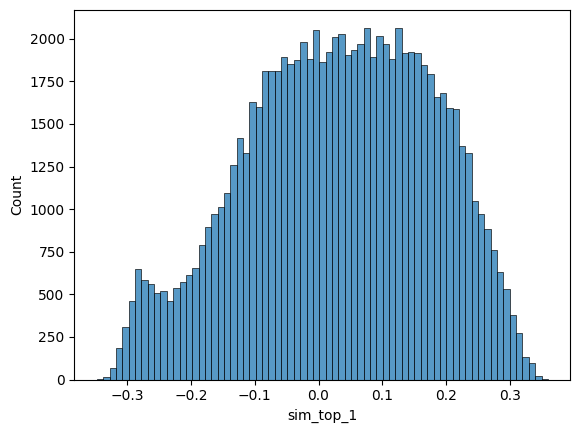

In [6]:
X_cat, X, Y = (
    categorical_data(data),
    prepare_data(data).drop("popularity", axis=1),
    data["popularity"],
)

print(X_cat.columns)

print(X.columns)
sns.histplot(X["sim_top_1"])
plt.show()

In [7]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, train_test_split
from tqdm import tqdm

data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

X_cat_train, X_train = (
    categorical_data(data_train),
    prepare_data(data_train, reset=True).drop("popularity", axis=1),
)
Y_train = data_train["popularity"] - (
    cat_model := LinearRegression().fit(X_cat_train, data_train["popularity"])
).predict(X_cat_train)

X_cat_test, X_test = (
    categorical_data(data_test),
    prepare_data(data_test).drop("popularity", axis=1),
)
Y_test = data_test["popularity"]

models = []

for train_idx, _ in tqdm(KF.split(X_train)):
    X_tr, Y_tr = X_train.iloc[train_idx], Y_train.iloc[train_idx]

    Y_tr -= sum([model.predict(X_tr) for model in models])

    models.append(
        RandomForestRegressor(
            n_estimators=1000, n_jobs=-1, max_features=1 / 3, min_samples_split=10
        ).fit(X_tr, Y_tr)
    )

5it [02:17, 27.41s/it]


Test R^2 score: 0.5762985108072478


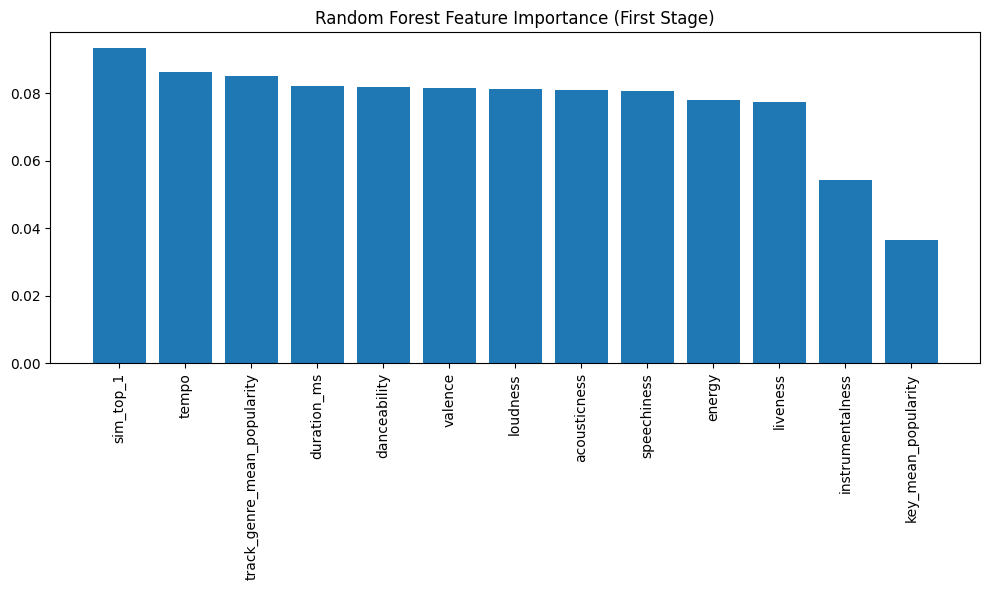

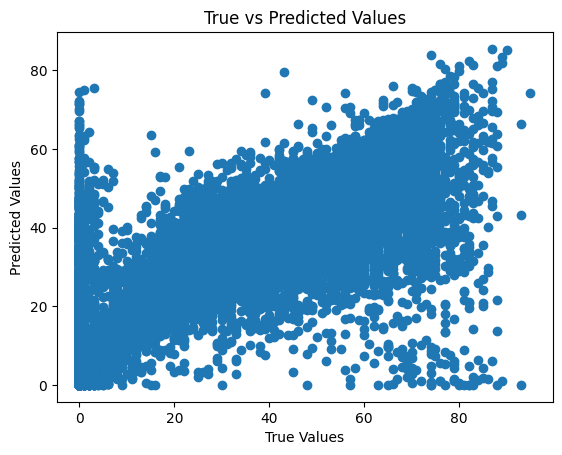

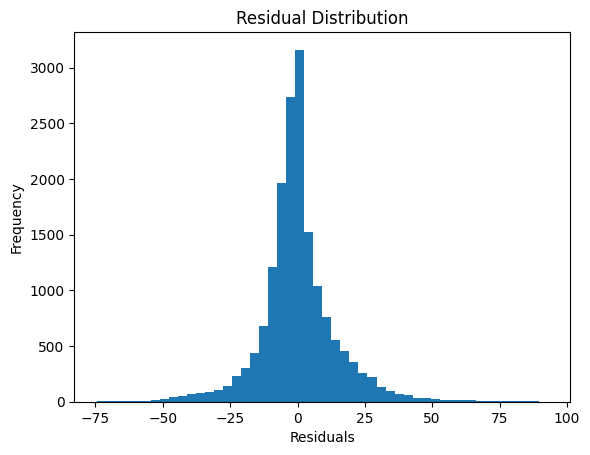

In [8]:
y_test_pred = np.clip(cat_model.predict(X_cat_test) + sum([model.predict(X_test) for model in models]), 0, 100)
print("Test R^2 score:", r2_score(Y_test, y_test_pred))

indices = models[0].feature_importances_.argsort()[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), models[0].feature_importances_[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.title("Random Forest Feature Importance (First Stage)")
plt.tight_layout()
plt.show()

plt.scatter(Y_test, y_test_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

plt.hist(Y_test - y_test_pred, bins=50)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

In [9]:
# Retrain full model
Y -= (cat_model := LinearRegression().fit(X_cat, Y)).predict(X_cat)

models = []

for train_idx, _ in tqdm(KF.split(X)):
    X_tr, Y_tr = X.iloc[train_idx], Y.iloc[train_idx]

    Y_tr -= sum([model.predict(X_tr) for model in models])

    models.append(
        RandomForestRegressor(
            n_estimators=1000, n_jobs=-1, max_features=1 / 3, min_samples_split=10
        ).fit(X_tr, Y_tr)
    )

5it [03:02, 36.46s/it]


In [11]:
import datetime

# Load test data
data_test = pd.read_csv("data/test_data.csv")

# Prepare test data
X_cat_test,X_test = categorical_data(data_test), prepare_data(data_test)

# Make predictions
Y_pred = np.clip(cat_model.predict(X_cat_test) + sum([model.predict(X_test) for model in models]), 0, 100)

# Save predictions, index is row_id
Y_pred_df = pd.DataFrame(Y_pred, columns=["popularity"])
Y_pred_df.index = data_test["row_id"]

# Save CSV
filename = "pred/pred_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + ".csv"
Y_pred_df.to_csv(filename, index_label="row_id")